# A stochastic and deterministic model for insect population dynamics under SIT inervention

The goal of this notebook is to simulate the population dynamics of a pest insect species under the Sterile Insect Technique (SIT) intervention. Both brith-death process and dynamic models are used to simulate the population dynamics. 

The BD model is used when the total population is under a chosen threshold, and the dynamic model is used when the population is above the threshold. The two models are coupled together to simulate the population dynamics over time. 

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

## Parameters and functions

In [117]:
# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
#egg_death = 0.2     # Death rate per egg
adult_death = 0.091  # Death rate per adult
sterile_death = adult_death*1.2   # Death rate per sterile
init_egg = 0  # Starting egg population
init_f0 = 10 # Starting female population
init_ff = 10 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 10 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp = 0.000001 # Carrying capacity 
n_rel = 0

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant
# Initialize variables

sterile_hist = 0
t = 0
time_history = [t]
pop = np.array([init_egg, init_f0, init_ff, init_fs, init_male, init_sterile], dtype=int)
population_history = [(pop[0], pop[1], pop[2], pop[3], pop[4], pop[5])]
Mat_events = np.array([[30, -1, 0, 0],
              [-1, 0, 0, 0],
              [0,-1, 0, 0],
              [0, 0, -1, 0],
              [-1, 1, 0, 0],
              [-1, 0, 1, 0],
              [0, 0, 0, -1]], dtype=np.int8)

# Initialize variables

n_intervals = 1000//7
days = np.linspace(0, 1000, 100001)  # Time steps
pop = np.array([init_egg, init_f0, init_ff, init_fs, init_male, init_sterile])  # Initial population

In [118]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15
def temperature_const(t,offset = 0): # Constant temperature
    return 273.15 + 28.0

In [119]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 28.0) + 273.15

def transition_rate(evt, T, R0, Ha, Hh, T12, R): # Transition rate function from one state to another
    return R0[evt]*(T/298)*np.exp(Ha[evt]*(1/298 - 1/T)/R)/(1 + np.exp(Hh[evt]*(1/T12[evt] - 1/T)/R))

def adult_rate(T, R0, Ha, Hh, T12, R): # Transition rate function from larvae to pupae to adult
    egg_transi = transition_rate(0, T, R0, Ha, Hh, T12, R)
    larvae_transi = transition_rate(1, T, R0, Ha, Hh, T12, R)
    pupae_transi = transition_rate(2, T, R0, Ha, Hh, T12, R)
    death_L = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)
    death_P = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)

    return egg_transi*larvae_transi*pupae_transi/((pupae_transi + death_P) * (larvae_transi + death_L))

# definition of the different mortality rates : 
def egg_death(T) : 
    if T < 288 : 
        return 0
    else :
        return 0.011 # A calculer

In [120]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 1000

def release2(M, n):
    return 0

In [121]:
def det_step(y, t, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = y

    T = temperature(t, 100)
    if T < 286:
        print("Temperature low")

    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
        adult_death = 0.091
    if M + Ms == 0:
        probaM = 0
        probaMs = 0
    else:
        probaM = M / (2 * M + Ms)
        probaMs = Ms / (2 * M + Ms)
    matf = mating(0.01*M, 0.001*Ms)* probaM
    mats = mating(0.001*Ms, 0.01*M)* probaMs
    
    # Differential equations
    dE_dt = n_egg * birth * Ff - death_egg * E
    dF_dt = mu * transi * E - (matf + mats + adult_death) * F
    dFf_dt = matf * F - adult_death * Ff
    dFs_dt = mats * F - adult_death * Fs
    dM_dt = (1 - mu) * transi * E - adult_death * 1.2 * M
    dMs_dt = - adult_death * 1.2 * 1.2 * Ms
    return [dE_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt]

def det_model(pop, interval, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil):
    population_history = [(pop[0], pop[1], pop[2], pop[3], pop[4], pop[5])]
    time_history = [interval[0]]
    dt = interval[1] - interval[0]    
    for i in range(len(interval)):
        t = interval[i]
        pop = pop + np.array(det_step(pop, t, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R)) * dt
        population_history.append((max(0, pop[0]), max(0, pop[1]), max(0, pop[2]), max(0, pop[3]), max(0, pop[4]), max(0, pop[5])))
        time_history.append(t)
        if pop[1] + pop[2] < seuil:
            print("Population low ! :)")
            return population_history, time_history
        
        if sum(pop) == 0 or pop[0] + pop[1] + pop[2] == 0:
            print("No life :(")
            break 
        
    return population_history, time_history

In [122]:
def sto_model1(pop, interval, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil):
    population_history = [(int(pop[0]), int(pop[1]), int(pop[2]), int(pop[3]), int(pop[4]), int(pop[5]))]
    time_history = [interval[0]]
    t = interval[0]
    while t < interval[-1] :
        T = temperature_const(t, 100)
    
        egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
    
        if T < 286:
            death_egg = 0.001
            egg_adult_rate = 0
            adult_death = 1.5*adult_death
        else :    
            death_egg = egg_death(T) + comp * pop[0] + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate)
            adult_death = 0.091
        if pop[4] + pop[5] == 0:
            prob_M = 0
            prob_Ms = 0
        else:
            prob_M = pop[4]/(pop[4] + pop[5])
            prob_Ms = pop[5]/(pop[4] + pop[5])

        total_rate = ( birth * pop[2] +
            (death_egg) * pop[0]+
            adult_death *(pop[1] + pop[2] + pop[3] + pop[4]) +
            mu * egg_adult_rate * pop[0] +
            (1 - mu) * egg_adult_rate * pop[0] +
            sterile_death * pop[5] +  
            mating(0.01*pop[4], 0.001*pop[5]) * prob_M * pop[1] +
            mating(0.001*pop[5], 0.01*pop[4]) * prob_Ms * pop[1])
    
        if total_rate == 0: # In that case, nobody survived
            print("No life :(")
            return pop

        # Step 2: Draw time to next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        t += time_to_next_event

        # Step 4: Determine the event
        p = np.random.rand()

        if p < (birth * pop[2]) / total_rate:
            pop[0] += n_egg
        elif p < (egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[1] += 1
        elif p < (egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[4] += 1
        elif p < (death_egg * pop[0] + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
        elif p < (adult_death * pop[1] + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
        elif p < (adult_death * (pop[1] + pop[2]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[2] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[3] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[4] -= 1
        elif p < (sterile_death * pop[5] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[5] -= 1
        elif p < (mating(0.01*pop[4], 0.001*pop[5])* prob_M * pop[1] + sterile_death * pop[5] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
            pop[2] +=1
        else :
            pop[1] -= 1
            pop[3] += 1

        # Step 5: Record history
        time_history.append(t)
        population_history.append((max(pop[0], 0), max(pop[1], 0), max(pop[2], 0), max(pop[3], 0), max(pop[4], 0), max(pop[5], 0)))

        if sum(pop) == 0 or pop[0] + pop[1] + pop[2] == 0:
            print("No life :(")
            break 
    
        if min(pop) < 0:
            print("Negative population :(")
            break

        if pop[1] + pop[2] > seuil:
            print("Population too high !")
            print("Population at time", t, ":", pop)
            break
    
    if t >= interval[-1]:
        time_history[-1] = interval[-1]
    print("Population at time", time_history[-1], ":", pop)
    return population_history, time_history

In [123]:
def sto_model2(pop, interval, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil):
    population_history = [(int(pop[0]), int(pop[1]), int(pop[2]), int(pop[3]), int(pop[4]), int(pop[5]))]
    time_history = [interval[0]]
    t = interval[0]
    while t < interval[-1] :
        T = temperature_const(t, 100)
    
        egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
        
        if pop[5] < 1:
            pop[5] = 0

        if pop[4] < 1:
            pop[4] = 0
    
        if T < 286:
            death_egg = 0.001
            egg_adult_rate = 0
            adult_death = 1.5*adult_death
        else :    
            death_egg = egg_death(T) + comp * pop[0] + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate)
            adult_death = 0.091
        if pop[4] + pop[5] == 0:
            prob_M = 0
            prob_Ms = 0
        else:
            prob_M = pop[4]/(pop[4] + pop[5])
            prob_Ms = pop[5]/(pop[4] + pop[5])

        total_rate = ( birth * pop[2] +
            (death_egg) * pop[0]+
            adult_death *(pop[1] + pop[2] + pop[3] + pop[4]) +
            mu * egg_adult_rate * pop[0] +
            (1 - mu) * egg_adult_rate * pop[0] +
            mating(0.01*pop[4], 0.001*pop[5]) * prob_M * pop[1] +
            mating(0.001*pop[5], 0.01*pop[4]) * prob_Ms * pop[1])
    
        if total_rate == 0: # In that case, nobody survived
            print("No life :(")
            return pop

        # Step 2: Draw time to next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        t += time_to_next_event

        # We compute the number of sterile males using deterministic model
        pop[5] += - adult_death * 1.2 * pop[5] * time_to_next_event

        # Step 4: Determine the event
        p = np.random.rand()

        if p < (birth * pop[2]) / total_rate:
            pop[0] += n_egg
        elif p < (egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[1] += 1
        elif p < (egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[4] += 1
        elif p < (death_egg * pop[0] + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
        elif p < (adult_death * pop[1] + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
        elif p < (adult_death * (pop[1] + pop[2]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[2] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[3] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[4] -= 1
        elif p < (mating(0.01*pop[4], 0.001*pop[5])* prob_M * pop[1] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
            pop[2] +=1
        else :
            pop[1] -= 1
            pop[3] += 1

        # Step 5: Record history
        time_history.append(t)
        population_history.append((max(pop[0], 0), max(pop[1], 0), max(pop[2], 0), max(pop[3], 0), max(pop[4], 0), max(pop[5], 0)))

        if sum(pop) == 0 or pop[0] + pop[1] + pop[2] == 0:
            print("No life :(")
            break 

        if min(pop) < 0:
            print("Negative population :(")
            break

        if pop[1] + pop[2] > seuil:
            print("Population too high !")
            print("Population at time", t, ":", pop)
            break

    if t >= interval[-1]:
        time_history[-1] = interval[-1]
    print("Population at time", time_history[-1], ":", pop)
    return population_history, time_history

In [124]:
def branching1(pop, interval, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil):
    population_history = [(int(pop[0]), int(pop[1]), int(pop[2]), int(pop[3]), int(pop[4]), int(pop[5]))]
    time_history = [interval[0]]
    t = interval[0]
    while t < interval[-1] :
        T = temperature_const(t, 100)
    
        egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
        
        if pop[5] < 1:
            pop[5] = 0
            
        if pop[4] < 1:
            pop[4] = 0
    
        if T < 286:
            death_egg = 0.001
            egg_adult_rate = 0
            adult_death = 1.5*adult_death
        else :    
            death_egg = egg_death(T) + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate) # No more competition in this state
            adult_death = 0.091
        if pop[4] + pop[5] == 0:
            prob_M = 0
            prob_Ms = 0
        else:
            prob_M = pop[4]/(pop[4] + pop[5])
            prob_Ms = pop[5]/(pop[4] + pop[5])

        total_rate = ( birth * pop[2] +
            (death_egg) * pop[0]+
            adult_death *(pop[1] + pop[2] + pop[3] + pop[4]) +
            mu * egg_adult_rate * pop[0] +
            (1 - mu) * egg_adult_rate * pop[0] +
            mating(0.01*pop[4], 0.001*pop[5]) * prob_M * pop[1] +
            mating(0.001*pop[5], 0.01*pop[4]) * prob_Ms * pop[1])
    
        if total_rate == 0: # In that case, nobody survived
            print("No life :(")
            return pop

        # Step 2: Draw time to next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        t += time_to_next_event

        # We compute the number of sterile males using deterministic model
        pop[5] += - adult_death * 1.2 * pop[5] * time_to_next_event

        # Step 4: Determine the event
        p = np.random.rand()

        if p < (birth * pop[2]) / total_rate:
            pop[0] += n_egg
        elif p < (egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[1] += 1
        elif p < (egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[4] += 1
        elif p < (death_egg * pop[0] + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
        elif p < (adult_death * pop[1] + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
        elif p < (adult_death * (pop[1] + pop[2]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[2] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[3] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[4] -= 1
        elif p < (mating(0.01*pop[4], 0.001*pop[5])* prob_M * pop[1] + adult_death * (pop[1] + pop[2] + pop[3] + pop[4]) + death_egg * pop[0]  + egg_adult_rate * (1 - mu) * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
            pop[2] +=1
        else :
            pop[1] -= 1
            pop[3] += 1

        # Step 5: Record history
        time_history.append(t)
        population_history.append((max(pop[0], 0), max(pop[1], 0), max(pop[2], 0), max(pop[3], 0), max(pop[4], 0), max(pop[5], 0)))

        if sum(pop) == 0 or pop[0] + pop[1] + pop[2] == 0:
            print("No life :(")
            break 

        if min(pop) < 0:
            print("Negative population :(")
            break

        if pop[1] + pop[2] > seuil:
            print("Population too high !")
            print("Population at time", t, ":", pop)
            break

    if t >= interval[-1]:
        time_history[-1] = interval[-1]
    print("Population at time", time_history[-1], ":", pop)
    return population_history, time_history

In [125]:
def branching2(pop, interval, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil):
    population_history = [(int(pop[0]), int(pop[1]), int(pop[2]), int(pop[3]), int(pop[4]), int(pop[5]))]
    time_history = [interval[0]]
    t = interval[0]
    while t < interval[-1] :
        T = temperature_const(t, 100)
    
        egg_adult_rate = adult_rate(T, R0, Ha, Hh, T12, R)
        
        if pop[5] < 1:
            pop[5] = 0

        if pop[4] < 1:
            pop[4] = 0
    
        if T < 286:
            death_egg = 0.001
            egg_adult_rate = 0
            adult_death = 1.5*adult_death
        else :    
            death_egg = egg_death(T) + (transition_rate(0, T, R0, Ha, Hh, T12, R) - egg_adult_rate) + (1 - mu) * egg_adult_rate # No more competition in this state + removal when transi to male
            adult_death = 0.091
        if pop[4] + pop[5] == 0:
            prob_M = 0
            prob_Ms = 0
        else:
            prob_M = pop[4]/(pop[4] + pop[5])
            prob_Ms = pop[5]/(pop[4] + pop[5])

        total_rate = ( birth * pop[2] +
            death_egg * pop[0]+
            adult_death *(pop[1] + pop[2] + pop[3]) +
            mu * egg_adult_rate * pop[0] +
            mating(0.01*pop[4], 0.001*pop[5]) * prob_M * pop[1] +
            mating(0.001*pop[5], 0.01*pop[4]) * prob_Ms * pop[1])
    
        if total_rate == 0: # In that case, nobody survived
            print("No life :(")
            return pop

        # Step 2: Draw time to next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        t += time_to_next_event

        # We compute the number of sterile males using deterministic model
        pop[5] += - adult_death * 1.2 * pop[5] * time_to_next_event
        pop[4] += ((1 - mu) * egg_adult_rate * pop[0] - adult_death * pop[4]) * time_to_next_event

        # Step 4: Determine the event
        p = np.random.rand()

        if p < (birth * pop[2]) / total_rate:
            pop[0] += n_egg
        elif p < (egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
            pop[1] += 1
        elif p < (death_egg * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate and pop[0] > 0:
            pop[0] -= 1
        elif p < (adult_death * pop[1] + death_egg * pop[0]  + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
        elif p < (adult_death * (pop[1] + pop[2]) + death_egg * pop[0] + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[2] -= 1
        elif p < (adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[3] -= 1
        elif p < (mating(0.01*pop[4], 0.001*pop[5])* prob_M * pop[1] + adult_death * (pop[1] + pop[2] + pop[3]) + death_egg * pop[0]  + egg_adult_rate * mu * pop[0] + birth * pop[2]) / total_rate:
            pop[1] -= 1
            pop[2] +=1
        else :
            pop[1] -= 1
            pop[3] += 1

        # Step 5: Record history
        time_history.append(t)
        population_history.append((max(pop[0], 0), max(pop[1], 0), max(pop[2], 0), max(pop[3], 0), max(pop[4], 0), max(pop[5], 0)))

        if sum(pop) == 0 or pop[0] + pop[1] + pop[2] == 0:
            print("No life :(")
            break 

        if min(pop) < 0:
            print("Negative population :(")
            break

        if pop[1] + pop[2] > seuil:
            print("Population too high !")
            print("Population at time", t, ":", pop)
            break

    if t >= interval[-1]:
        time_history[-1] = interval[-1]
    print("Population at time", time_history[-1], ":", pop)
    return population_history, time_history

In [162]:

def sim1(n_intervals, pop_init, days, birth, adult_death, comp, mu, R0, Ha, Hh, T12, R, methode = 1, n_egg = 64, seuil = 200):
    # Solve the differential equations
    time_history = [0]
    temp_time = []
    pop0 = pop_init
    E, F, Ff, Fs, M, Ms = [pop0[0]], [pop0[1]], [pop0[2]], [pop[3]], [pop0[4]], [pop0[5]]
    # Divide the time in n_intervals
    taille_intervals = len(days)//n_intervals
    intervals = [days[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [days[(n_intervals - 1) * taille_intervals :]]
    print(len(intervals))
    for interval in intervals: # We look at the population size each week.
        study = interval
        a = study[0]
        b = study[-1]
        print("New interval with first time", a, "and last time", b)

        if (study[0] > 300) & (F[-1] + Ff[-1] + Fs[-1]> 500):
            Ms[-1] = Ms[-1] + release1(M[-1],50)
            print("release", Ms[-1])
            pop0[5] = Ms[-1]
        while a != b:
            temp_time = []


            if pop0[1] + pop0[2] < seuil:
                #make sure before that pop0 are int
                pop0 = [int(x) for x in pop0]
                print("c sto !")
                if methode == 1:
                    solution, temp_time = sto_model1(
                        pop0, study, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil
                    )

                elif methode == 2:
                    solution, temp_time = sto_model2(
                        pop0, study, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil
                    )

                elif methode == 3:
                    solution, temp_time = branching1(
                        pop0, study, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil
                    )
                
                elif methode == 4:
                    solution, temp_time = branching2(
                        pop0, study, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil
                    )

                E0, F0, Ff0, Fs0, M0, Ms0 = [pop[0] for pop in solution], [pop[1] for pop in solution], [pop[2] for pop in solution], [pop[3] for pop in solution], [pop[4] for pop in solution], [pop[5] for pop in solution]
                E.extend(map(int, E0))
                F.extend(map(int, F0))
                Ff.extend(map(int, Ff0))
                Fs.extend(map(int, Fs0))
                M.extend(map(int, M0))
                Ms.extend(map(int, Ms0))
                time_history.extend(temp_time)   

                if b != temp_time[-1]:
                    a = temp_time[-1]
                    # We define a new interval from a to b keeping the inbeetween values of the previous interval
                    if a > b:
                        print("bizarre")
                        a = b
                    if a < b:
                        # Get the index of the closest occurrence to 'a' in 'interval'
                        index = np.where(study >= a)[0]
                        study = study[index[0]:]
                        #else :
                        #    a = b
                        print("new a", a)
                        print("new b", b)

                pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]

                # If everybody's dead, we stop the simulation
                if sum(pop0) == 0 or pop0[0] + pop0[1] + pop0[2] == 0:
                    print("At time ", temp_time[-1], ", no life :(")
                    return E, F, Fs, Ff, M, Ms, time_history
                if min(pop0) < 0:
                    print("At time ", temp_time[-1], ", negative population :(")
                    return E, F, Fs, Ff, M, Ms, time_history
                
            if a != b and pop0[1] + pop0[2] > seuil:
                print("c det !")
                solution, temp_time = det_model(
                    pop0, study, birth, n_egg, adult_death, comp, mu, R0, Ha, Hh, T12, R, seuil
                )
                E0, F0, Ff0, Fs0, M0, Ms0 = [pop[0] for pop in solution], [pop[1] for pop in solution], [pop[2] for pop in solution], [pop[3] for pop in solution], [pop[4] for pop in solution], [pop[5] for pop in solution]

                E.extend(E0)
                F.extend(F0)
                Ff.extend(Ff0)
                Fs.extend(Fs0)
                M.extend(M0)
                Ms.extend(Ms0)
                time_history.extend(temp_time)

                if b != temp_time[-1]:
                    a = temp_time[-1]
                    # We define a new interval from a to b keeping the inbeetween values of the previous interval
                    if a > b:
                        print("bizarre")
                        a = b
                    if a < b:
                        # Get the index of the closest occurrence to 'a' in 'interval'
                        index = np.where(study >= a)[0]
                        #if len(index) > 0:  # Ensure the index exists
                        study = study[index[0]:]
                        #else :
                        #    a = b
                        print("new a", a)
                        print("new b", b)

                pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]

            # If everybody's dead, we stop the simulation
                if sum(pop0) == 0 or pop0[0] + pop0[1] + pop0[2] == 0:
                    print("At time ", temp_time[-1], ", no life :(")
                    return E, F, Fs, Ff, M, Ms, time_history
                if min(pop0) < 0:
                    print("At time ", temp_time[-1], ", negative population :(")
                    return E, F, Fs, Ff, M, Ms, time_history
            if b == temp_time[-1]:
                break
            
    return E, F, Fs, Ff, M, Ms, time_history

## Results

In [178]:
# Run the simulation
E, F, Ff, Fs, M, Ms, time = sim1(n_intervals, pop, days, birth, adult_death, comp, mu, R0 , Ha, Hh , T12, R, 4)
print(max(E), max(F), max(Ff), max(Fs), max(M), max(Ms))
print(min(E), min(F), min(Ff), min(Fs), min(M), min(Ms))

142
New interval with first time 0.0 and last time 7.03
c sto !
Population at time 7.03 : [1353, 9, 9, 0, np.float64(14.741470583650695), 0.0]
New interval with first time 7.04 and last time 14.07
c sto !
Population at time 14.07 : [2403, 15, 14, 0, np.float64(32.57297493266985), 0.0]
New interval with first time 14.08 and last time 21.11
c sto !
Population at time 21.11 : [5594, 18, 40, 0, np.float64(63.164123266638065), 0.0]
New interval with first time 21.12 and last time 28.150000000000002
c sto !
Population at time 28.150000000000002 : [14770, 42, 116, 0, np.float64(157.20150714194202), 0.0]
New interval with first time 28.16 and last time 35.19
c sto !
Population too high !
Population at time 29.39086997947607 : [18812, 61, 140, 0, np.float64(189.40500443647377), 0.0]
Population at time 29.39086997947607 : [18812, 61, 140, 0, np.float64(189.40500443647377), 0.0]
new a 29.39086997947607
new b 35.19
c det !
New interval with first time 35.2 and last time 42.230000000000004
c det !


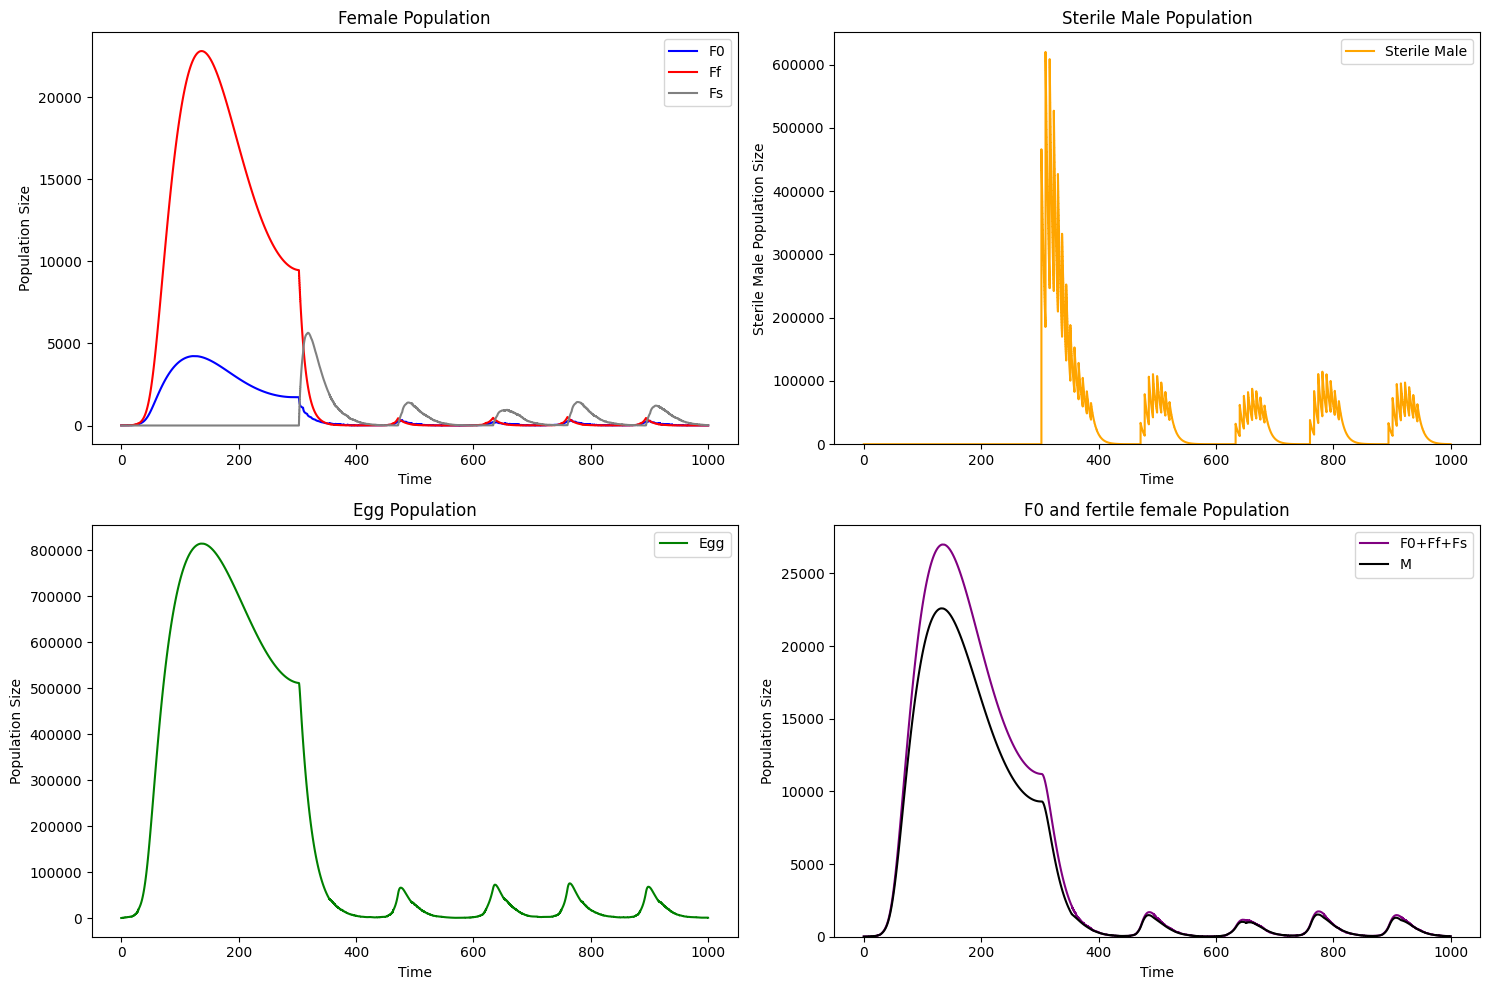

In [179]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(time, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(time, Fs, where="post", label='Ff', color = 'red')
axs[0, 0].step(time, Ff, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(time, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(time, E, where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(time,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(time, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


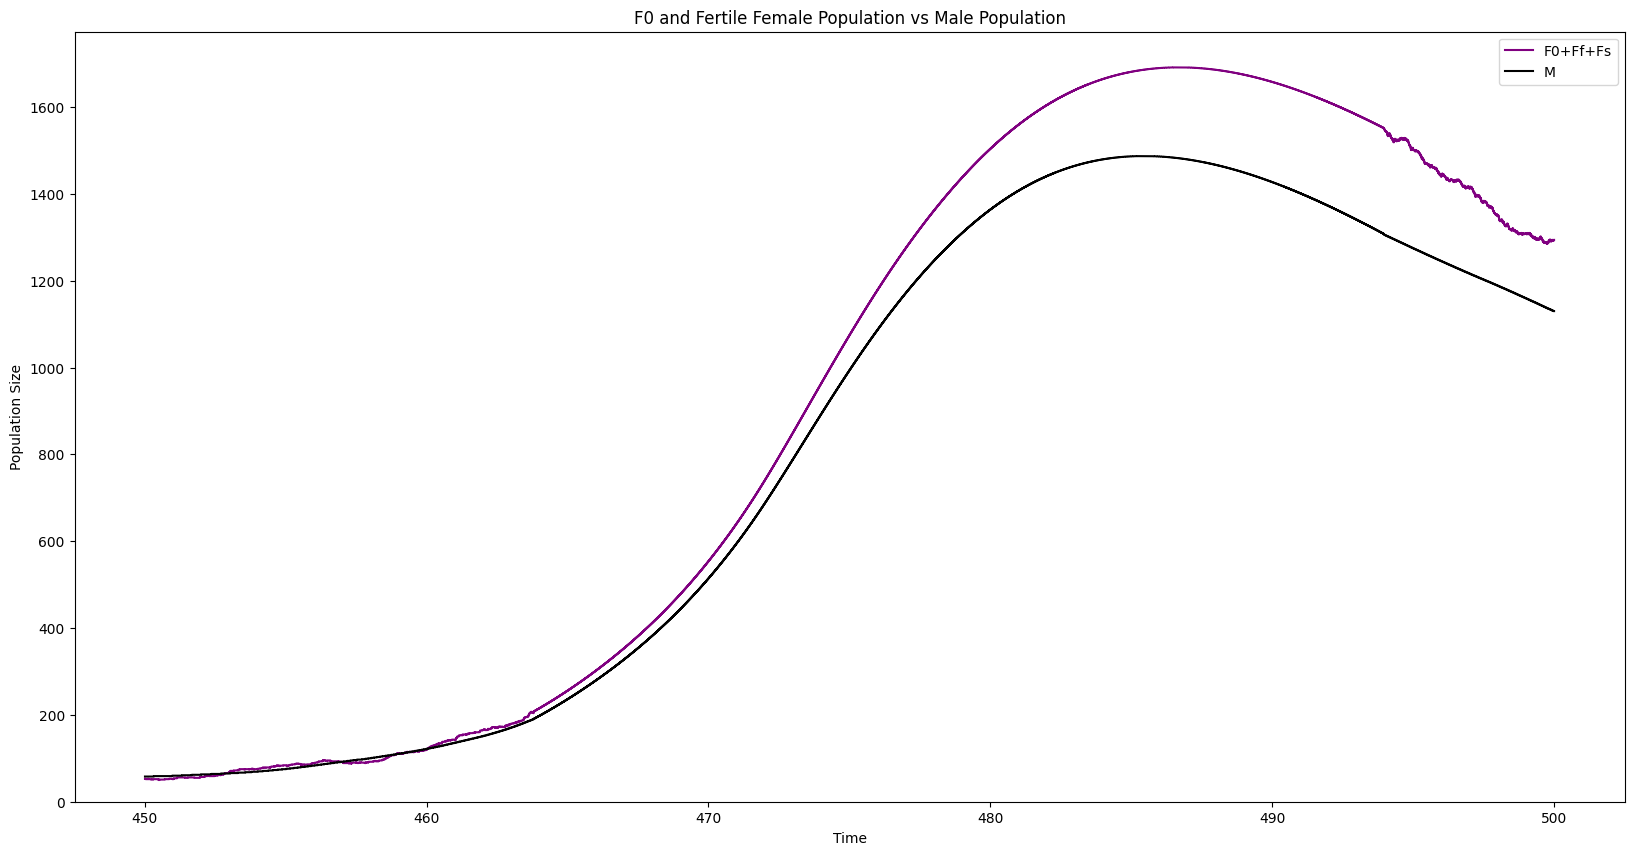

In [180]:
# Plot the female (F0 + Ff+ Fs) and M population on the interval 780 to 1000
# Convert time to a NumPy array for comparison
time_array = np.array(time)

# Plot the female (F0 + Ff + Fs) and M population on the interval 780 to 1000
# Ensure x and y have the same length
valid_indices = np.where(np.logical_and(time_array >= 450, time_array <= 500))[0]
time_filtered = time_array[valid_indices]
female_population = [F[i] + Ff[i] + Fs[i] for i in valid_indices]

plt.figure(figsize=(20, 10))
plt.step(time_filtered, female_population, where="post", label='F0+Ff+Fs', color='purple')
plt.step(time_filtered, [M[i] for i in valid_indices], where="post", label='M', color='black')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.ylim(bottom=0)
plt.title('F0 and Fertile Female Population vs Male Population')
plt.legend()
plt.show()
